In [164]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [144]:
data = pd.read_csv("./course_lead_scoring.csv")
data.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [145]:
data.columns = data.columns.str.lower().str.replace(' ', '_')
cols = data.columns
cat_cols = list(data.dtypes[data.dtypes == object].index)
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove('converted')

In [146]:
data[cat_cols] = data[cat_cols].fillna('NA')
data[num_cols] = data[num_cols].fillna(0)
data.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [147]:
X_train_full, X_test, y_train_full, y_test = train_test_split(data, data['converted'], train_size=0.8, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, X_train_full['converted'],train_size=0.75, random_state=1)

del X_train['converted']
del X_val['converted']
del X_test['converted']

In [148]:
for col in num_cols:
    print(f"{col}: {roc_auc_score(y_train, X_train[col])}")

number_of_courses_viewed: 0.7635680590007088
annual_income: 0.5519578313253012
interaction_count: 0.738270176293409
lead_score: 0.6144993577250176


In [149]:
dicts_train = X_train[cat_cols + num_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_trainohe = dv.fit_transform(dicts_train)

dicts_val = X_val[cat_cols + num_cols].to_dict(orient='records')
X_valohe = dv.transform(dicts_val)


In [150]:

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_trainohe, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [153]:
# preds = model.predict(X_valohe)
# roc_preds = round(roc_auc_score(y_val, preds),3)
y_preds = model.predict_proba(X_valohe)[:, 1]
round(roc_auc_score(y_val, y_preds),3)
# print(roc_preds, roc_y_preds)


0.817

In [152]:
threshhold = np.arange(0, 1.01, 0.01)
scores = []

for t in threshhold:
    actual_pos = (y_val == 1)
    actual_neg = (y_val == 0)

    preds_pos = (y_preds >= t)
    preds_neg = (y_preds < t)

    tp = (preds_pos & actual_pos).sum()
    tn = (preds_neg & actual_neg).sum()

    fp = (preds_pos & actual_neg).sum()
    fn = (preds_neg & actual_pos).sum()

    scores.append((t, tp, fp , fn, tn))

In [158]:
columns = ['threshhold', 'TP', 'FP', 'FN', 'TN']
df_scores = pd.DataFrame(scores, columns= columns)
df_scores["Precision"] = df_scores['TP'] / (df_scores['FP'] + df_scores["TP"])
df_scores["Recall"] = df_scores['TP'] / (df_scores['FN'] + df_scores["TP"])
df_scores['f1'] = 2 * ((df_scores["Precision"] * df_scores["Recall"]) / (df_scores["Precision"] + df_scores["Recall"]) )

In [163]:
df_scores['f1'].sort_values(ascending=False)
df_scores.iloc[57]

threshhold      0.570000
TP            156.000000
FP             57.000000
FN             15.000000
TN             65.000000
Precision       0.732394
Recall          0.912281
f1              0.812500
Name: 57, dtype: float64

In [157]:
# df_scores.loc[df_scores["threshhold"] == 0.55]
# df_scores[df_scores['Precision'] == df_scores['Recall']]
# df_scores['Diff'] = (df_scores['Precision'] - df_scores['Recall']).abs()
# df_scores['Diff']
idx = np.argwhere(np.diff(np.sign(df_scores['Precision'] - df_scores['Recall']))).flatten()
df_scores.iloc[idx]

,threshhold,TP,FP,FN,TN,Precision,Recall
64,0.64,134,38,37,84,0.77907,0.783626
97,0.97,1,0,170,122,1.00000,0.005848
98,0.98,0,0,171,122,NaN,0.000000
99,0.99,0,0,171,122,NaN,0.000000


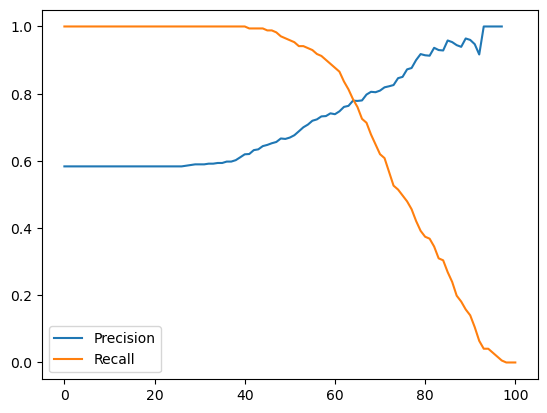

In [140]:
plt.plot(df_scores['Precision'], label= 'Precision')
plt.plot(df_scores['Recall'], label= 'Recall')
plt.legend()

In [173]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
k_scores = []

for train_idx, val_idx in kfold.split(X_train_full):
    k_X_train = X_train_full.iloc[train_idx]
    k_X_val = X_train_full.iloc[val_idx]

    k_y_train = k_X_train.converted.values
    k_y_val = k_X_val.converted.values

    k_dicts_train = k_X_train[cat_cols + num_cols].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    k_X_trainohe = dv.fit_transform(k_dicts_train)

    k_dicts_val = k_X_val[cat_cols + num_cols].to_dict(orient='records')
    k_X_valohe = dv.transform(k_dicts_val)

    k_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    k_model.fit(k_X_trainohe, k_y_train)

    k_preds = k_model.predict_proba(k_X_valohe)[:,1]
    k_scores.append(roc_auc_score(k_y_val, k_preds))

np.std(k_scores)

np.float64(0.03580711942905165)

In [174]:
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    k_scores = []
    for train_idx, val_idx in kfold.split(X_train_full):
        k_X_train = X_train_full.iloc[train_idx]
        k_X_val = X_train_full.iloc[val_idx]

        k_y_train = k_X_train.converted.values
        k_y_val = k_X_val.converted.values

        k_dicts_train = k_X_train[cat_cols + num_cols].to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        k_X_trainohe = dv.fit_transform(k_dicts_train)

        k_dicts_val = k_X_val[cat_cols + num_cols].to_dict(orient='records')
        k_X_valohe = dv.transform(k_dicts_val)

        k_model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        k_model.fit(k_X_trainohe, k_y_train)

        k_preds = k_model.predict_proba(k_X_valohe)[:,1]
        k_scores.append(roc_auc_score(k_y_val, k_preds))

    print(f"C: {C}, std: {round(np.std(k_scores),3)}, mean: {round(np.mean(k_scores),3)}")

C: 1e-06, std: 0.024, mean: 0.56
C: 0.001, std: 0.029, mean: 0.867
C: 1, std: 0.036, mean: 0.822
